# Taxi demand prediction in New York City

In [0]:
import math,pickle, os, scipy, matplotlib

import dask.dataframe as dd#similar to pandas
import pandas as pd#pandas to create small dataframes 
import numpy as np

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

# import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
# matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
import folium #open street map

# unix time: https://www.unixtimestamp.com/
import datetime 
import time #Convert to unix time

import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

In [0]:
d = '/content/drive/My Drive/Colab Notebooks/Dataset/Yellow Taxi Demand/'

# 1. Data Information

* Ge the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml (2016 data)
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC)

## Information on taxis:

* **Yellow Taxi**: Yellow Medallion Taxicabs
  * These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.

* **For Hire Vehicles (FHVs)**
  * FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged.

* **Green Taxi: Street Hail Livery (SHL)** 
  * The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides. 
<p> Credits: Quora</p>

**Footnote**
In the given notebook we are considering only the yellow taxis for the time period between Jan - Mar 2015 & Jan - Mar 2016


# 2. Data Collection

We Have collected all yellow taxi trips data from jan-2015 to dec-2016(Will be using only 2015 data)

| File Name | File size | Number of Records | Number of Features |
|-----------|-----------|-------------------|--------------------|
|yellow_tripdata_2016-01| 1. 59G| 10906858 | 19|
| yellow_tripdata_2016-02 | 1. 66G | 11382049 | 19 |
| yellow_tripdata_2016-03 | 1. 78G | 12210952 | 19 |
| yellow_tripdata_2016-04 | 1. 74G | 11934338 | 19 |
| yellow_tripdata_2016-05 | 1. 73G | 11836853 | 19 |
| yellow_tripdata_2016-06 | 1. 62G | 11135470 | 19 |
| yellow_tripdata_2016-07 |  884Mb | 10294080 | 17 |
| yellow_tripdata_2016-08 |  854Mb | 9942263  | 17 |
| yellow_tripdata_2016-09 |  870Mb | 10116018 | 17 |
| yellow_tripdata_2016-10 |  933Mb | 10854626 | 17 |
| yellow_tripdata_2016-11 |  868Mb | 10102128 | 17 |
| yellow_tripdata_2016-12 |  897Mb | 10449408 | 17 |
| yellow_tripdata_2015-01 | 1.84Gb | 12748986 | 19 |
| yellow_tripdata_2015-02 | 1.81Gb | 12450521 | 19 |
| yellow_tripdata_2015-03 | 1.94Gb | 13351609 | 19 |
| yellow_tripdata_2015-04 | 1.90Gb | 13071789 | 19 |
| yellow_tripdata_2015-05 | 1.91Gb | 13158262 | 19 |
| yellow_tripdata_2015-06 | 1.79Gb | 12324935 | 19 |
| yellow_tripdata_2015-07 | 1.68Gb | 11562783 | 19 |
| yellow_tripdata_2015-08 | 1.62Gb | 11130304 | 19 |
| yellow_tripdata_2015-09 | 1.63Gb | 11225063 | 19 |
| yellow_tripdata_2015-10 | 1.79Gb | 12315488 | 19 |
| yellow_tripdata_2015-11 | 1.65Gb | 11312676 | 19 |
| yellow_tripdata_2015-12 | 1.67Gb | 11460573 | 19 |

In [5]:
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
month = dd.read_csv(d+'yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


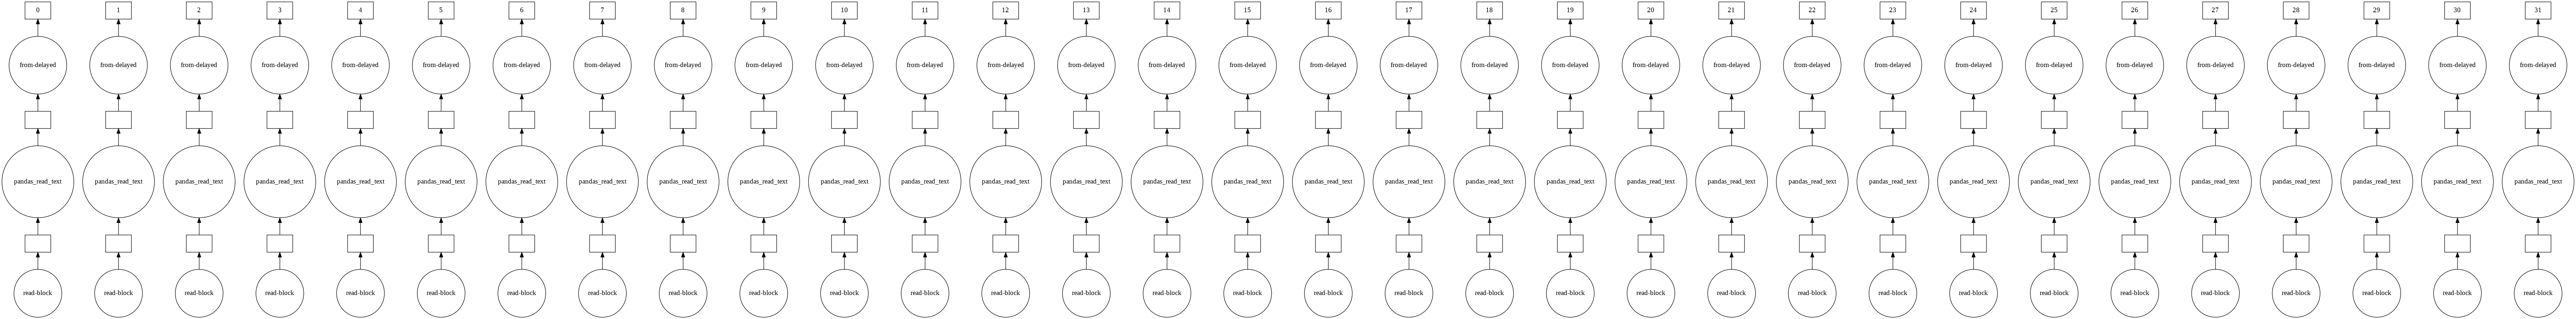

In [6]:
month.visualize()

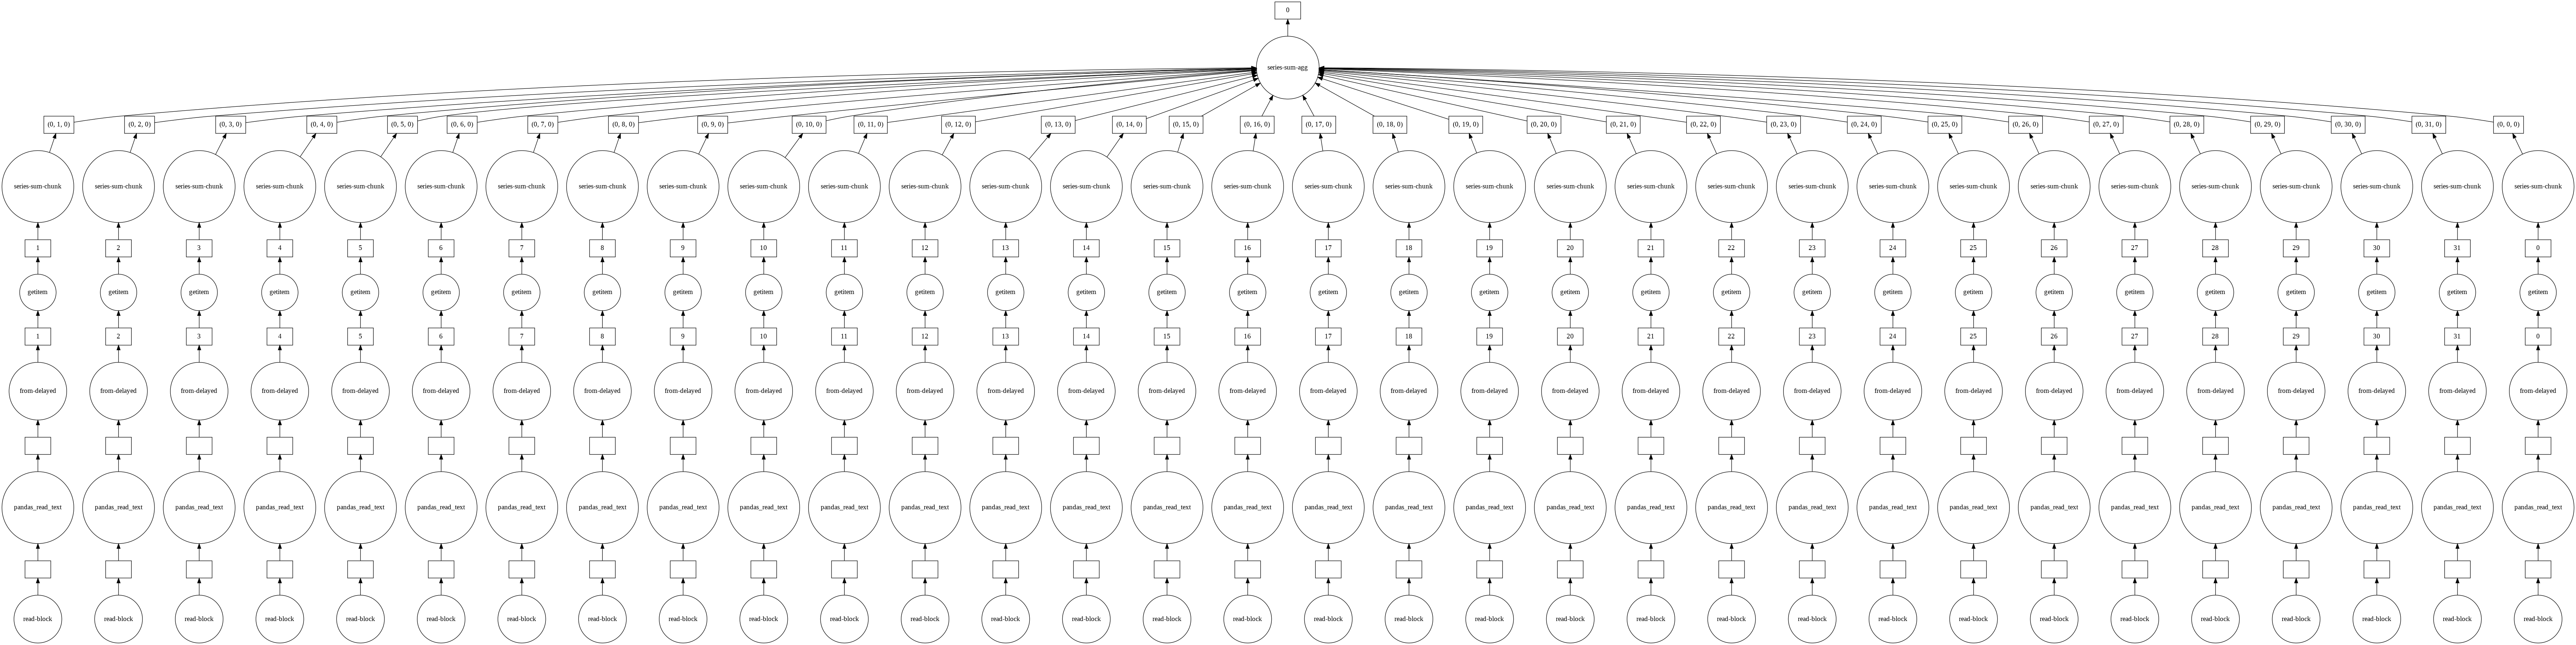

In [7]:
month.fare_amount.sum().visualize()

| Field Name| Description |
|-----------|-------------|
| VendorID  |1. A code indicating the TPEP provider that provided the record.<br>2. Creative Mobile Technologies <br>3. VeriFone Inc. |	
| tpep_pickup_datetime| The date and time when the meter was engaged.|	
|tpep_dropoff_datetime| The date and time when the meter was disengaged.|
|Passenger_count| The number of passengers in the vehicle. This is a driver-entered value.|	
|Trip_distance| The elapsed trip distance in miles reported by the taximeter.|	
|Pickup_longitude| Longitude where the meter was engaged.|	
|Pickup_latitude|Latitude where the meter was engaged.|	
|RateCodeID|1. The final rate code in effect at the end of the trip. <br>2. Standard rate <br>3. JFK <br> 4. Newark <br> 5. Nassau or Westchester <br>6. Negotiated fare <br>7. Group ride|
|Store_and_fwd_flag|This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br>aka “store and forward,” because the vehicle did not have a connection to the server.<br>Y= store and forward trip<br>N= not a store and forward trip|
|Dropoff_longitude|Longitude where the meter was disengaged.|	
|Dropoff_ latitude|Latitude where the meter was disengaged.|
|Payment_type| A numeric code signifying how the passenger paid for the trip.<br> 1.Credit card <br> 2. Cash <br> 3. No charge <br> 4. Dispute <br>5. Unknown <br> 6. Voided trip|
|Fare_amount|The time-and-distance fare calculated by the meter.|
|Extra|Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.|
|MTA_tax|0.50 MTA tax that is automatically triggered based on the metered rate in use.|
|Improvement_surcharge|0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.|
|Tip_amount|Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.|	
|Tolls_amount|Total amount of all tolls paid in trip.|	
|Total_amount|The total amount charged to passengers. Does not include cash tips.|

# 3. ML Problem Formulation

**Time-series forecasting and Regression**
* To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.
* To solve the above we would be using data collected in Jan - Mar 2015 to predict the pickups in Jan - Mar 2016.

# 4. Performance metrics

1. Mean Absolute percentage error.
2. Mean Squared error.

# 5. Data Cleaning

* In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

In [8]:
#table below shows few datapoints along with all our features
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


## 5.1 Pickup Latitude and  Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

* Plotting pickup cordinates which are outside the bounding box of New-York

In [9]:
# coordinated outside of NYC in outlier_locations
outlier_locations = month[((month['pickup_longitude'] <= -74.15) | (month['pickup_latitude'] <= 40.5774)| \
                   (month['pickup_longitude'] >= -73.7004) | (month['pickup_latitude'] >= 40.9176))]

# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Terrain')

# we will spot only first 1000 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

In [10]:
# shape of dask dataframe: https://stackoverflow.com/a/57040523
a = outlier_locations.shape
b = a[0].compute(),a[1]
print('There are total {} datapoints outside of NYC based on Pickup location in Jan of 2015.'.format(b[0]))

There are total 247742 datapoints outside of NYC based on Pickup location in Jan of 2015.


**Observation:** As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada

## 5.2 Dropoff Latitude & Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

* Plotting pickup cordinates which are outside the bounding box of New-York

In [11]:
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month['dropoff_longitude'] <= -74.15) | (month['dropoff_latitude'] <= 40.5774)| \
                   (month['dropoff_longitude'] >= -73.7004) | (month['dropoff_latitude'] >= 40.9176))]

# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Terrain')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

In [12]:
# shape of dask dataframe: https://stackoverflow.com/a/57040523
a = outlier_locations.shape
b = a[0].compute(),a[1]
print('There are total {} datapoints outside of NYC based on Dropoff location in Jan of 2015.'.format(b[0]))

There are total 264440 datapoints outside of NYC based on Dropoff location in Jan of 2015.


**Observation:** The observations here are similar to those obtained while analysing pickup latitude and longitude



## 5.3 Trip Durations

* According to NYC Taxi & Limousine Commision Regulations **the maximum allowed trip duration in a 24 hour interval is 12 hours.**
* The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 
* In our data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert this string to python time format and then into unix time stamp

* We'll create a new data frame which contains following columns
    * 1.**passenger_count**  
    * 2.**trip_distance** 
    * 3.**pickup_longitude** 
    * 4.**pickup_latitude** 
    * 5.**dropoff_longitude** 
    * 6.**dropoff_latitude** 
    * 7.**total_amount** : total fair that was paid
    * 8.**trip_times** : duration of each trip (in minutes)
    * 9.**pickup_times** : pickup time converted into unix time 
    * 10.**Speed** : velocity of each trip (miles/hr)

In [0]:
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    new_frame = month[['passenger_count','trip_distance','pickup_longitude',
                       'pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

In [14]:
frame_with_durations = return_with_trip_times(month)
frame_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378


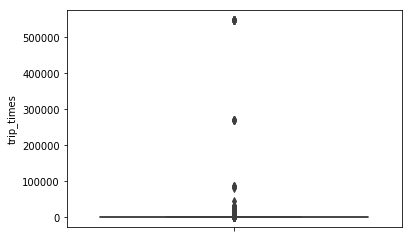

In [15]:
# let's see the box plot of time duration of trip
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

* the skewed box plot shows us the presence of outliers 

In [16]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
var =frame_with_durations["trip_times"].values
var = np.sort(var,axis = None)
for i in range(0,100,10):    
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [17]:
#looking further from the 90th percecntile
for i in range(90,100):   
    print("{} percentile value is {}".format(i, var[int(len(var)*(i/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.6333333333


* Based on __TLC__ reguations maximum trip-duration can't be more than 12 hours = 720 minutes.
* So range of trip duration will be __1<= trip_time<=720__

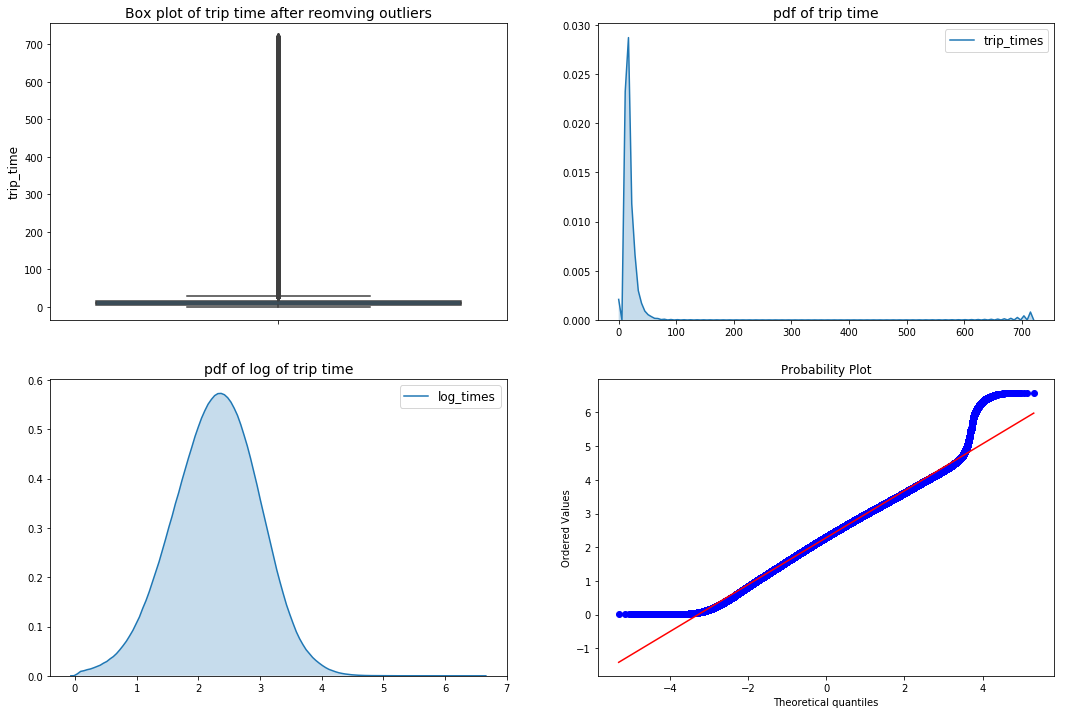

In [18]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations['trip_times']>1) & (frame_with_durations['trip_times']<720)]

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, figsize = (18, 12))
sns.boxplot(y="trip_times", data =frame_with_durations_modified, ax = ax1)
ax1.set_title('Box plot of trip time after reomving outliers', fontsize = 14)
ax1.set_ylabel('trip_time', fontsize = 12)

sns.kdeplot(frame_with_durations_modified['trip_times'], shade=True, ax = ax2)
ax2.set_title('pdf of trip time', fontsize = 14)
ax2.legend(fontsize = 12)

#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

sns.kdeplot(frame_with_durations_modified['log_times'], shade=True, ax = ax3)
ax3.set_title('pdf of log of trip time', fontsize = 14)
ax3.legend(fontsize = 12)

scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=ax4)

plt.show()


* From box plot we can say that data is highly skewed.
* From pdf plot it is clear that *__trip_time__* feature is right skewed and it look somewhat similar to *__log-normal__* plot. But not sure.
* In order to be sure, plot **log of *'trip_time'*** and **Q-Q** plot. But from **Q-Q** plot it is clear that *__trip_time__* does not follow the log-normal distribution

## 5.4 Speed

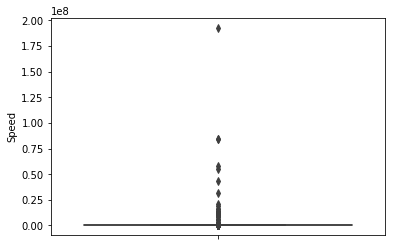

In [19]:
# box-plot for speeds with outliers
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [20]:
#0,10,20,30,40,50,60,70,80,90,100th peercentile of speed values  
var = frame_with_durations_modified["Speed"].values
var = np.sort(var,axis = None)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [21]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


In [22]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print('{} percentile is {}'.format(99.99, var[int(len(var) * (99+0.99)/100)]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
99.99 percentile is 60.420091324200904
100 percentile value is  192857142.85714284


* Removing further outliers based on the __99.99th percentile__ value of __speed__ which is 60.42 miles/hr.

In [23]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations['Speed']>0) & (frame_with_durations['Speed']<60.42)]

#avg.speed of cabs in New-York
print('Average speed of taxi is: ',np.mean(frame_with_durations_modified['Speed']), ' miles/hr')

Average speed of taxi is:  12.484228267030732  miles/hr


* After removing outliers the **average speed** of yellow taxi in NYC is **12.48 miles/hr**. 

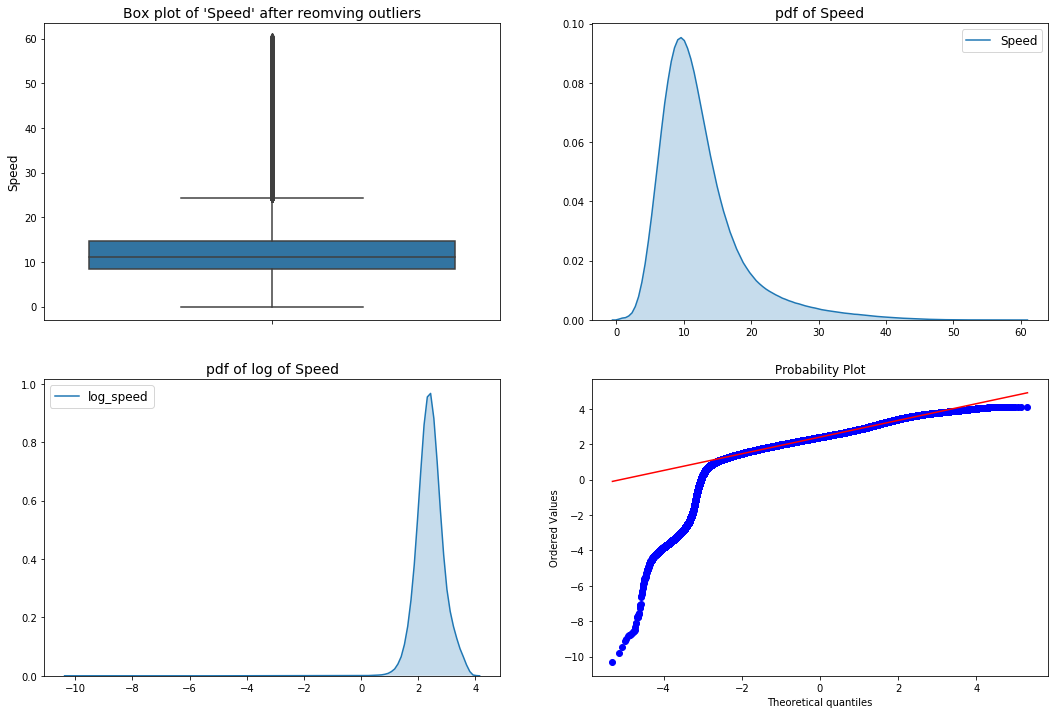

In [24]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, figsize = (18, 12))

sns.boxplot(y="Speed", data =frame_with_durations_modified, ax = ax1)
ax1.set_title("Box plot of 'Speed' after reomving outliers", fontsize = 14)
ax1.set_ylabel('Speed', fontsize = 12)

sns.kdeplot(frame_with_durations_modified['Speed'], shade=True, ax = ax2)
ax2.set_title('pdf of Speed', fontsize = 14)
ax2.legend(fontsize = 12)

frame_with_durations_modified['log_speed']=[math.log(i) for i in frame_with_durations_modified['Speed'].values]

sns.kdeplot(frame_with_durations_modified['log_speed'], shade=True, ax = ax3)
ax3.set_title('pdf of log of Speed', fontsize = 14)
ax3.legend(fontsize = 12)

scipy.stats.probplot(frame_with_durations_modified['log_speed'].values, plot=ax4)

plt.show()

* From __box plot__ and __pdf plot__ of *__Speed__* feature we can see that it is __right skewed__.
* __pdf plot__ of __log of *Speed*__ and __Q-Q plot__ it is clear that it is not __log-normal__ distributed.

In [25]:
avg_speed = np.mean(frame_with_durations_modified['Speed'])
print("The average speed in NYC is {} miles/hr, so cab driver can travel {} miles(aprrox.) in 10 minutes interval"
     .format(avg_speed, round(10*avg_speed/60)))

The average speed in NYC is 12.484228267030732 miles/hr, so cab driver can travel 2 miles(aprrox.) in 10 minutes interval


<b style='font-size:16px'>The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel <font color='blue'> 2 miles per 10min on avg.</font> </b>

## 5.5 Trip Distance

Up to now outliers has been removed based on trip duration and cab speed. Let's see the box-plot of *__trip_distance__* features

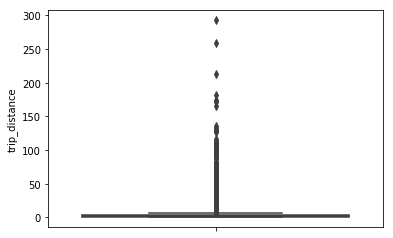

In [26]:
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

* Not much clear from box-plot. We can only say that *__trip_distacne__* feature is skewed.
* Let's see the percentile values.

In [27]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
var =frame_with_durations_modified["trip_distance"].values
var = np.sort(var,axis = None)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.7
60 percentile value is 2.08
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 6.0
100 percentile value is  293.68


* There is too much varaition from 90th to 100th percentile. So let's see from 90th to 100th percentile.

In [28]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 6.0
91 percentile value is 6.5
92 percentile value is 7.1
93 percentile value is 7.9
94 percentile value is 8.8
95 percentile value is 9.69
96 percentile value is 10.7
97 percentile value is 12.28
98 percentile value is 16.26
99 percentile value is 18.22
100 percentile value is  293.68


* There is too much variation from 99th to 100th percentile. So let's see hte values between 99th and 100th percentile.

In [29]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("{} percentile value is {}".format(99.99, var[int(len(var)*(float(99+0.99)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.22
99.1 percentile value is 18.42
99.2 percentile value is 18.67
99.3 percentile value is 18.91
99.4 percentile value is 19.22
99.5 percentile value is 19.6
99.6 percentile value is 20.09
99.7 percentile value is 20.64
99.8 percentile value is 21.39
99.9 percentile value is 23.0
99.99 percentile value is 36.1
100 percentile value is  293.68


* Removing datapoints whose trip distance is more than 99.99th percentile value of trip distance. So removing which are more than 36.1 miles. More than this much distance will be like special booking.

In [30]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations['trip_distance']>0) & (frame_with_durations['trip_distance']<36.1)]
print('Average trip distance is {} miles'.format(round(np.mean(frame_with_durations_modified['trip_distance'].values), 2)))

Average trip distance is 2.79 miles


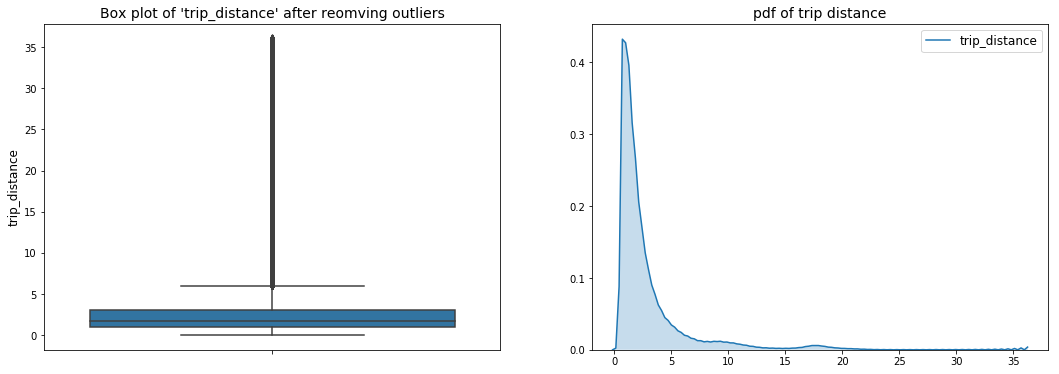

In [31]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (18, 6))

sns.boxplot(y="trip_distance", data =frame_with_durations_modified, ax = ax1)
ax1.set_title("Box plot of 'trip_distance' after reomving outliers", fontsize = 14)
ax1.set_ylabel('trip_distance', fontsize = 12)

sns.kdeplot(frame_with_durations_modified['trip_distance'], shade = True, ax = ax2)
ax2.set_title('pdf of trip distance', fontsize = 14)
ax2.legend(fontsize = 12)

plt.show()

* Average trip distance is 2.79 miles.
* Distribution of trip distance is right skewed.

## 5.6 Total Fare

* Up to now outliers has been removed based on trip speed, duration and speed. Let's see based on fair of a trip.

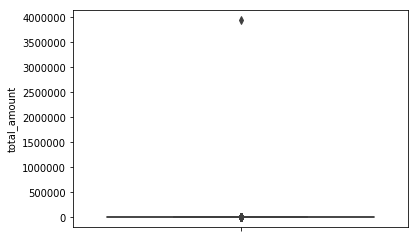

In [32]:
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

* Not much can be interpreted from above box-plot. So let's see the percentile values of trip fair.

In [33]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
var = frame_with_durations_modified["total_amount"].values
var = np.sort(var,axis = None)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


* To much change in trip fare from 90th to 100th percentile. So let's see between 90th to 100th percentile. 

In [34]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.35
92 percentile value is 29.38
93 percentile value is 32.0
94 percentile value is 35.16
95 percentile value is 38.8
96 percentile value is 42.8
97 percentile value is 48.76
98 percentile value is 58.13
99 percentile value is 68.0
100 percentile value is  3950611.6


* To much change in total fair from 99th to 100th percentile. So let's see the between 99.1 to 100th percentile.

In [35]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 68.0
99.1 percentile value is 69.05
99.2 percentile value is 69.6
99.3 percentile value is 69.69
99.4 percentile value is 69.73
99.5 percentile value is 69.76
99.6 percentile value is 72.46
99.7 percentile value is 72.66
99.8 percentile value is 79.13
99.9 percentile value is 94.05
100 percentile value is  3950611.6


__Observation:-__ As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis.
* Let's look at the top 100 total fairs.
* Based on knee-point, threshold of total fair will be decided. More than this total fair will be considered as special booking or extra-tip.

In [36]:
var[-10]

875.8

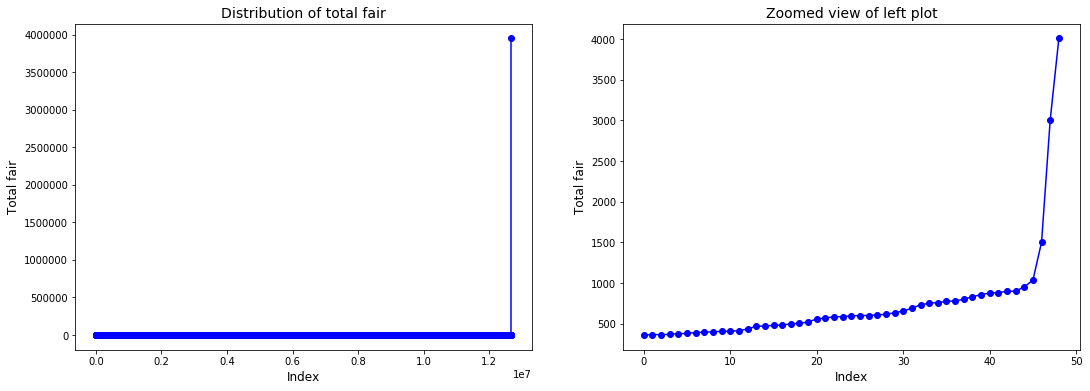

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,6))

ax1.plot(var, 'bo-')
ax1.set_title('Distribution of total fair', fontsize = 14)
ax1.set_ylabel('Total fair', fontsize = 12)
ax1.set_xlabel('Index', fontsize = 12)

ax2.plot(var[-50:-1], 'bo-')
ax2.set_title('Zoomed view of left plot', fontsize = 14)
ax2.set_xlabel('Index', fontsize = 12)
ax2.set_ylabel('Total fair', fontsize = 12)

plt.show()

In [38]:
print("Knee-point is at total fair = ", var[-5])

Knee-point is at total fair =  1034.46


* So more than 1000 total fair will be considered as outliers.

In [39]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations['total_amount']>0) & (frame_with_durations['total_amount']<1000)]
print('Average trip fair is {} dollars'.format(round(np.mean(frame_with_durations_modified['total_amount'].values), 2)))

Average trip fair is 14.81 dollars


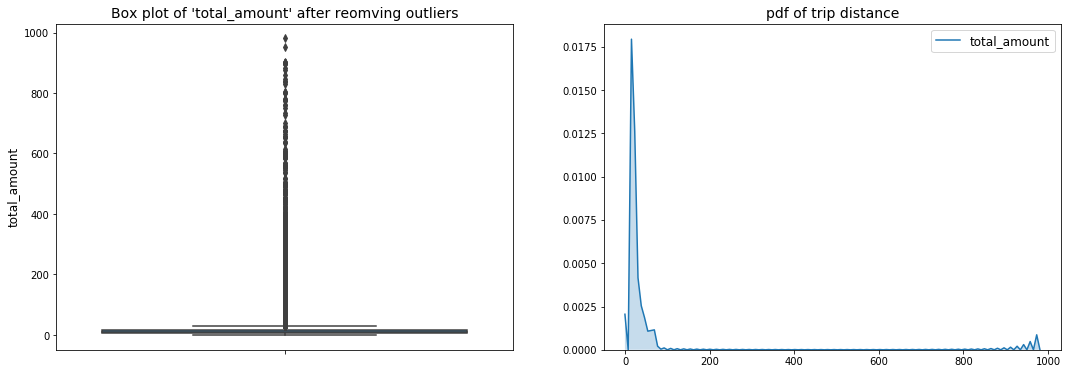

In [40]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (18, 6))

sns.boxplot(y="total_amount", data =frame_with_durations_modified, ax = ax1)
ax1.set_title("Box plot of 'total_amount' after reomving outliers", fontsize = 14)
ax1.set_ylabel('total_amount', fontsize = 12)

sns.kdeplot(frame_with_durations_modified['total_amount'], shade = True, ax = ax2)
ax2.set_title('pdf of trip distance', fontsize = 14)
ax2.legend(fontsize = 12)

plt.show()

* After removing the datapoints whose trip fair is more than 1000 dollars, the distribution pg *__total_amount__* feature is highly right skewed.

## 5.7 Remove all outliers/erronous points.

In [0]:
def remove_outliers(new_frame):
    """removes all outliers based on our univariate analysis above"""    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame['dropoff_longitude'] >= -74.15) & (new_frame['dropoff_longitude'] <= -73.7004) &\
                       (new_frame['dropoff_latitude'] >= 40.5774) & (new_frame['dropoff_latitude'] <= 40.9176)) & \
                       ((new_frame['pickup_longitude'] >= -74.15) & (new_frame['pickup_latitude'] >= 40.5774)& \
                       (new_frame['pickup_longitude'] <= -73.7004) & (new_frame['pickup_latitude'] <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame['trip_distance'] > 0) & (new_frame['trip_distance'] < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame['Speed'] <= 60.42) & (new_frame['Speed'] >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame['total_amount'] <1000) & (new_frame['total_amount'] > 0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame['dropoff_longitude'] >= -74.15) & (new_frame['dropoff_longitude'] <= -73.7004) &\
                       (new_frame['dropoff_latitude'] >= 40.5774) & (new_frame['dropoff_latitude'] <= 40.9176)) & \
                       ((new_frame['pickup_longitude'] >= -74.15) & (new_frame['pickup_latitude'] >= 40.5774)& \
                       (new_frame['pickup_longitude'] <= -73.7004) & (new_frame['pickup_latitude'] <= 40.9176))]
    
    new_frame = new_frame[(new_frame['trip_times'] > 0) & (new_frame['trip_times'] <= 720)]
    new_frame = new_frame[(new_frame['trip_distance'] > 0) & (new_frame['trip_distance'] <= 36.1)]
    new_frame = new_frame[(new_frame['Speed'] <= 60.42) & (new_frame['Speed'] >= 0)]
    new_frame = new_frame[(new_frame['total_amount'] <= 1000) & (new_frame['total_amount'] > 0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [42]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24693
Number of outliers from fare analysis: 5275
Total outliers removed 360856
---
fraction of data points that remain after removing outliers 0.9716953175727073


# 6. Data Prepearation

## 6.1 Clustering/Segmentation

* Our cluster in such a way that most of inter-cluster distance is less than or equal to 2 miles and more than or equal to 0.5 miles.
* So min_dist between clusters should very close to 0.5 mile but not less than 0.5 mile.
* Pecentage of clusters which are in vicinity should be higher.

In [0]:
def find_min_distance(cluster_centers, cluster_len):
    less2 = []
    more2 = []
    neighbours = []
    min_dist = 1000
    
    for i in range(0, cluster_len):
        nice_points = 0
        worng_points = 0
        
        for j in range(0, cluster_len):
            if i != j:
                # gpxpy.geo.havaersine_distance will retrun the distance in kilomtere given coordinates in degrees
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1], cluster_centers[j][0], cluster_centers[j][1])
                # converting distance into miles
                min_dist = min(min_dist, distance/(1.60934*1000))
                
                if (distance/(1.60934*1000)) <= 2:
                    nice_points += 1
                else:
                    worng_points += 1
        less2.append(nice_points)
        more2.append(worng_points)
    neighbours.append(less2)
    print("On choosing a cluster size of ",cluster_len,
          "\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)),
          "\n% of clusters which are in the vicinity",np.ceil(sum(less2)/len(less2))*100/cluster_len, 
          "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),
          "\nMin inter-cluster distance = ",min_dist,"\n---")

    
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude',
                                                                                                                    'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    
    return cluster_centers, cluster_len

In [44]:
# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
% of clusters which are in the vicinity 20.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0587468022686919 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
% of clusters which are in the vicinity 25.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance =  0.6758151727862665 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
% of clusters which are in the vicinity 23.333333333333332 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.0 
Min inter-cluster distance =  0.5144484386246096 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity

__Inference:__ From above obsevation, number of clusters 30 would be good.

In [0]:
# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters = 30, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(
    frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

**Plotting the cluster centers**

In [46]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
tool_tips = kmeans.predict(cluster_centers)
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Terrain')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), 
                  popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1])),
                 tooltip = tool_tips[i]).add_to(map_osm)
map_osm

**Plotting the clusters:**

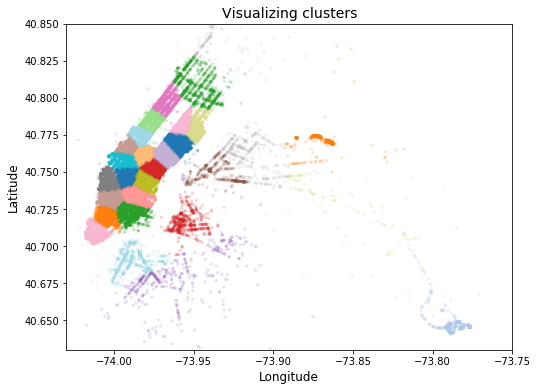

In [47]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (8,6))
    ax.scatter(frame['pickup_longitude'].values[:100000], frame['pickup_latitude'].values[:100000], s=10, lw=0,
               c=frame['pickup_cluster'].values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_title('Visualizing clusters', fontsize = 14)
    ax.set_xlabel('Longitude', fontsize = 12)
    ax.set_ylabel('Latitude', fontsize = 12)
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

## 6.2 Time Bining

Refer: https://www.unixtimestamp.com/
* 1420070400 : 2015-01-01 00:00:00 
* 1422748800 : 2015-02-01 00:00:00 
* 1425168000 : 2015-03-01 00:00:00
* 1427846400 : 2015-04-01 00:00:00 
* 1430438400 : 2015-05-01 00:00:00 
* 1433116800 : 2015-06-01 00:00:00


* 1451606400 : 2016-01-01 00:00:00 
* 1454284800 : 2016-02-01 00:00:00 
* 1456790400 : 2016-03-01 00:00:00
* 1459468800 : 2016-04-01 00:00:00 
* 1462060800 : 2016-05-01 00:00:00 
* 1464739200 : 2016-06-01 00:00:00

* We'll be converting time stamps into 10 minutes interval. 
* Unix time is in IST which is ahead of EST/EDT by 5 hours and 30 minutes.
* Pickup_times is time from EST/EDT zone, but we've converted into unix time stamp which is in GMT. So Actual conversion we should have added 4hr in this time.

In [0]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times = frame['pickup_times'].values    
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix = unix_times[year-2015][month-1]
#     https://www.timeanddate.com/time/zones/est
#     (int((i-start_pickup_unix)/600) + 33) : our unix time is in gmt to we are converting it to est    
#     tenminutewise_binned_unix_pickup_times = [(int((i-start_pickup_unix)/600) + 24) for i in unix_pickup_times]

    frame['pickup_bins'] = ((unix_pickup_times-start_pickup_unix)/600+33).astype(int) #using numpy array is much faster
#     numpy float to intiger type: https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-82.php

    return frame

In [49]:
frame_with_durations_outliers_removed.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319,1
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193,4
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269,18
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429,19
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378,14


* *__pickup_cluster__* is already added, now *__pickup_bins__* will be added.
* Then we'll groupby the dataframe by *__pickup_bins__* and *__pickup_cluster__* which will give the number of pickups at a time stamp (10 minutes interval time bin) for a location (or cluster).


In [50]:
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319,1,2163
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193,4,1452
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269,18,1452
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429,19,1452
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378,14,1452


* Hear the trip_distance represents the number of pickups that are happend in that particular 10min intravel.
* __jan_2015_groupby__ has only one column *__trip_distance__* which represents the number of pickups.
* __jan_205_groupby__ has two indices: (multi-index)
  * primary index : *__pickup_cluster__*
  * secondary index: *__pickup_bins__* (we devid whole months time into 10min intravels 24 * 31 * 60/10 =4464bins)

In [51]:
print("Column is: {}\nIndices are:\n  Primary: {}\n  Secondary:{}".format(jan_2015_groupby.columns[0],
                                                                         jan_2015_groupby.index.names[0], 
                                                                          jan_2015_groupby.index.names[1])) 
jan_2015_groupby.head()

Column is: trip_distance
Indices are:
  Primary: pickup_cluster
  Secondary:pickup_bins


trip_distance
pickup_cluster pickup_bins               
0              33                      97
               34                     210
               35                     332
               36                     328
               37                     336

Upto now we cleaned data and prepared data for the month 2015. Now do the same operations for months Jan, Feb, March of 2016.

* get the dataframe which inlcudes only required colums
* adding trip times, speed, unix time stamp of pickup_time
* remove the outliers based on trip_times, speed, trip_duration, total_amount
* add pickup_cluster to each data point
* add pickup_bin (index of 10min intravel to which that trip belongs to)
* group by data, based on 'pickup_cluster' and 'pickuo_bin'

In [0]:
def datapreparation(month, kmeans, month_no, year_no):
    
    print ("Return with trip times..")
    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 
                                                                                                                    'pickup_longitude']])
    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster',
                                                                                                         'pickup_bins']).count()
    print()    
    return final_updated_frame,final_groupby_frame

In [53]:
# Data Preparation for the months of Jan,Feb and March 2016
# reading the data in dask dataframe fromat    
month_jan_2016 = dd.read_csv(d+'yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv(d+'yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv(d+'yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21226
Number of outliers from fare analysis: 4991
Total outliers removed 281211
---
Estimating clusters..
Final groupbying..

Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22620
Number of outliers from fare analysis: 5476
Total outliers removed 293044
---
Estimating clusters..
Final groupbying..

Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers f

## 6.3 Smoothing

* Let's see per cluster how many time bins have zero number of pickups are in Jan, 2015.
* Get the unique bins where pickup value is present. In order to achieve this collect the indices where pickup happened. Then we'll **substract** the ***number of indices where pickup happened*** from ***4464*** (Jan month has 31 days = (31* 24* 60)/10 = 4464 bins)

In [0]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,30):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort() # since time series       
        values.append(list_unq)
    return values

* For every month we get all indices of 10min intravels in which atleast one pickup got happened.

In [0]:
#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [56]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(30):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  25
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  35
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  114
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  224
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  33
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  27
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  26
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  30
-----------

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

* In ***fill_missing*** function we fill value __0__ for every bin in each cluster if no pickup data is present. If  number of pickup value is present then we'll keep that value as it is.
* In ***smoothing*** function we'll replace the value which are '0' by using above stated method. But this would be done only for training data. We'll not do smoothing for test data. This will avoid data leakage. 
* As there are 30 clusters which devide NYC in different regions.
  * Jan has 31 days: So tatal number of bins = (31 * 24 * 60/10)*30 = 133920
  * Feb of 2016 had 29 days: So total number of bins = (29 * 24 * 60/10)*30 = 125280
  * March has 30 days: So total number of bins = (31 * 24 * 60/10)*30 = 133920

In [0]:
def fill_missing(count_values, values, month):
    if month == 2:
        days = 29
    else:
        days = 31
        
    bins_per_cluster = int(days*24*60/10)    
    fill_regions=[]
    ind=0
    
    for r in range(0,30):
        fill_bins=[]
        for i in range(bins_per_cluster):
            if i in values[r]:
                fill_bins.append(count_values[ind])
                ind+=1
            else:
                fill_bins.append(0)
        fill_regions.extend(fill_bins)
    return fill_regions

In [0]:
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    
    for r in range(0,30):
        smoothed_bins=[] #stores the final smoothed values of each cluster
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                            
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
        
    return smoothed_regions


In [59]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique, 1)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
print("number of 10min intravels among all the clusters in Jan 2015 after filling  :",len(jan_2015_fill),
      "\nnumber of 10min intravels among all the clusters in Jan 2015 after smoothing:", len(jan_2015_smooth) )

number of 10min intravels among all the clusters in Jan 2015 after filling  : 133920 
number of 10min intravels among all the clusters in Jan 2015 after smoothing: 133920


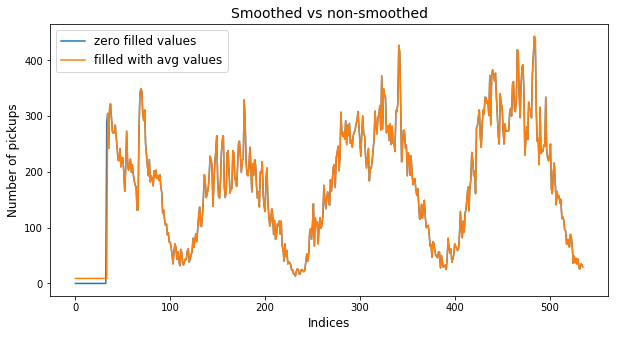

In [60]:
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:5000], label="zero filled values")
plt.plot(jan_2015_smooth[4464:5000], label="filled with avg values")
plt.title('Smoothed vs non-smoothed', fontsize = 14)
plt.ylabel('Number of pickups', fontsize=12)
plt.xlabel('Indices', fontsize=12)
plt.legend(fontsize = 12)
plt.show()

* When you are using smoothing we are looking at the future number of pickups which might cause a data leakage. so we use smoothing for jan 2015th data since it acts as our training data and we use simple fill_misssing method for 2016th data.

* number of 10min indices for jan 2015= 24*31*60/10 = 4464
* number of 10min indices for jan 2016 = 24*31*60/10 = 4464
* number of 10min indices for feb 2016 = 24*29*60/10 = 4176
* number of 10min indices for march 2016 = 24*31*60/10 = 4464
* regions_cum: it will contain 30 lists, each list will contain 4464+4176+4464 values which represents the number of pickups .
* that are happened for three months in 2016 data

In [61]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique, 1)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique, 2)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique, 3)
print('Length of Jan_2015_smooth:  {}\nLength of Jan_2016_smooth:  {}\nLength of feb_2016_smooth:  {}\nLength of mar_2016_smooth:  {}'
     .format(len(jan_2015_smooth), len(jan_2016_smooth), len(feb_2016_smooth), len(mar_2016_smooth)))

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []
for i in range(0,30):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])
print('Number of clusters: ',len(regions_cum))
print('Total numer of time bins per cluster: ', len(regions_cum[0]))


Length of Jan_2015_smooth:  133920
Length of Jan_2016_smooth:  133920
Length of feb_2016_smooth:  125280
Length of mar_2016_smooth:  133920
Number of clusters:  30
Total numer of time bins per cluster:  13104


## 6.4 Time series and Fourier Transforms

In [0]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
  
first_x = list(range(0,4464)) #of jan month
second_x = list(range(4464,8640)) # of feb month
third_x = list(range(8640,13104)) # of march month

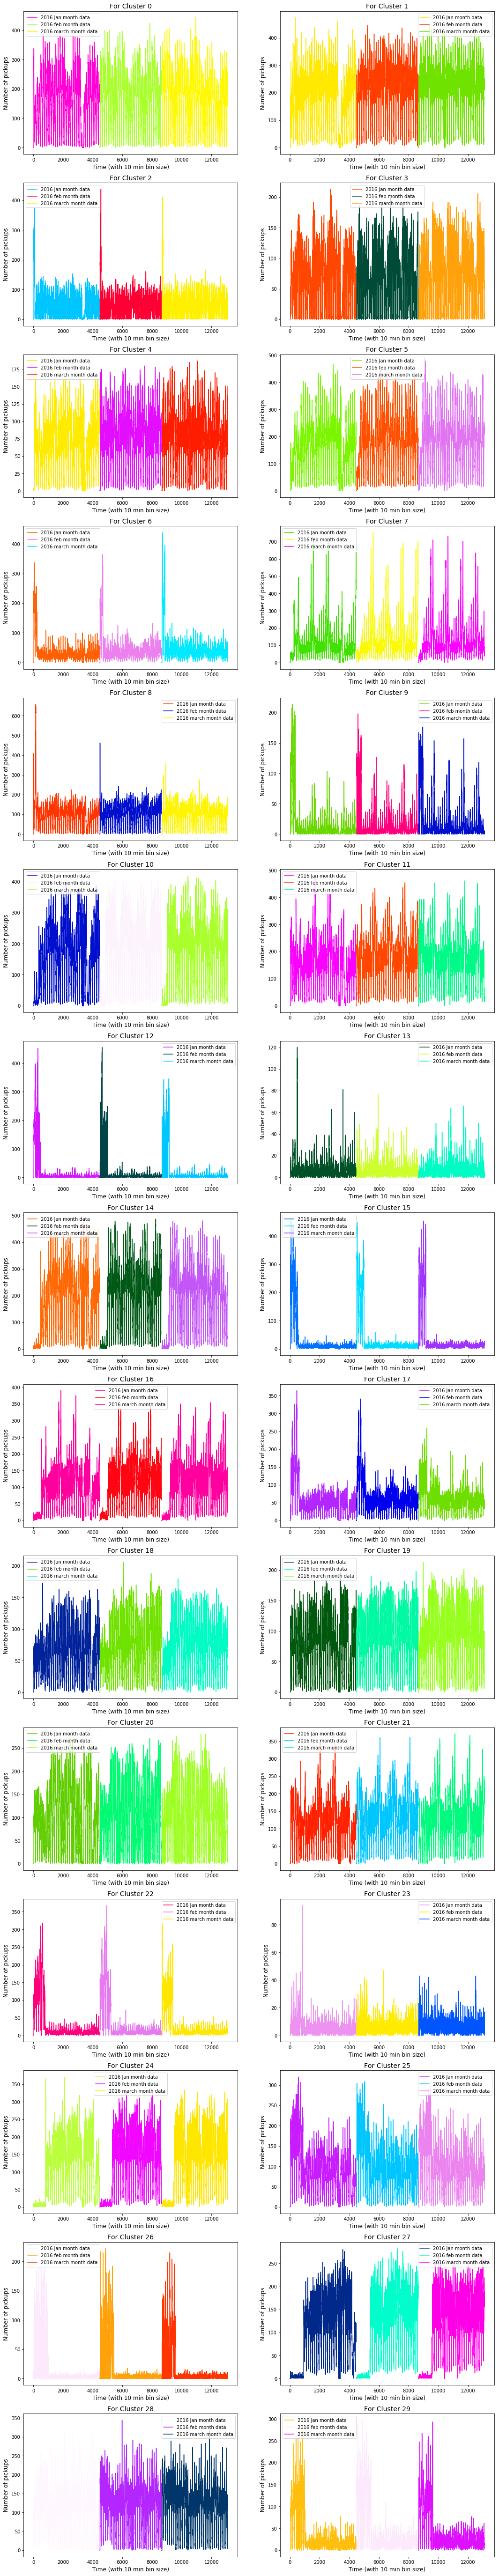

In [63]:
fig, axs = plt.subplots(15, 2, figsize = (18, 100))

for i, ax in enumerate(axs):
    ax1 = ax[0]
    ax2 = ax[1]
    j = i*2
    k = i*2+1
    ax1.plot(first_x,regions_cum[j][:4464], color=uniqueish_color(), label='2016 Jan month data')
    ax1.plot(second_x,regions_cum[j][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    ax1.plot(third_x,regions_cum[j][8640:], color=uniqueish_color(), label='2016 march month data')
    ax1.legend()
    ax1.set_title('For Cluster {}'.format(j), fontsize = 14)
    ax1.set_xlabel('Time (with 10 min bin size)', fontsize = 12)
    ax1.set_ylabel('Number of pickups', fontsize = 12)
    
    
    ax2.plot(first_x,regions_cum[k][:4464], color=uniqueish_color(), label='2016 Jan month data')
    ax2.plot(second_x,regions_cum[k][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    ax2.plot(third_x,regions_cum[k][8640:], color=uniqueish_color(), label='2016 march month data')
    ax2.legend()
    ax2.set_title('For Cluster {}'.format(k), fontsize = 14)
    ax2.set_xlabel('Time (with 10 min bin size)', fontsize = 12)
    ax2.set_ylabel('Number of pickups', fontsize = 12)
    
plt.show()

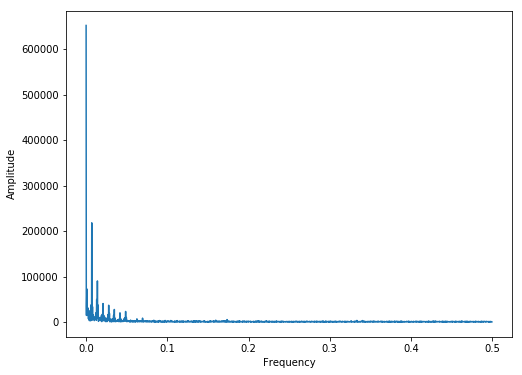

In [64]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])

# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)

plt.figure(figsize = (8,6))
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [0]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given'] = jan_2015_smooth
ratios_jan['Prediction'] = jan_2016_smooth
ratios_jan['Ratios'] = ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

# 7. Modelling

## 7.1 Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

### 7.1.1 Simple Moving Averages

* The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value.
* We'll using only Jan 2015 and Jan 2016 data for base line  models.

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [0]:
def MA_R_Predictions(ratios,month, window_size):
    predicted_ratio = (ratios['Ratios'].values)[0]
    error = []
    predicted_values = []
    window_size = window_size
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464 == 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

**Tunning**

Best window size is: 
  Based on MAPE: 2
  Based on MSE :5
But need validation!




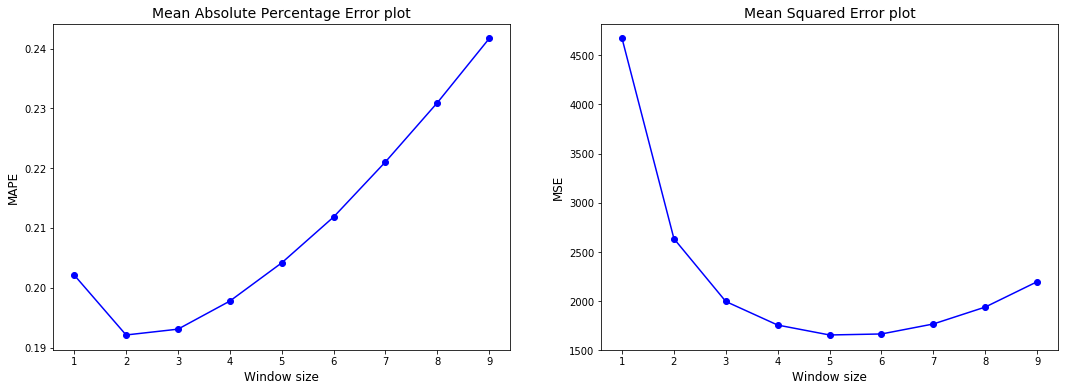

In [67]:
mape_errs = []
mse_errs = []
for window_size in range(1,10):
    a,b,c = MA_R_Predictions(ratios_jan,'jan', window_size)
    mape_errs.append(b)
    mse_errs.append(c)    

print('Best window size is: \n  Based on MAPE: {}\n  Based on MSE :{}\nBut need validation!\n\n'.format(mape_errs.index(min(mape_errs))+1,
                                                                             mse_errs.index(min(mse_errs))+1))
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (18,6))
ax1.plot(range(1,10), mape_errs, 'bo-')
ax1.set_title('Mean Absolute Percentage Error plot', fontsize = 14)
ax1.set_xlabel('Window size', fontsize = 12)
ax1.set_ylabel('MAPE', fontsize = 12)

ax2.plot(range(1,10), mse_errs, 'bo-')
ax2.set_title('Mean Squared Error plot', fontsize = 14)
ax2.set_xlabel('Window size', fontsize = 12)
ax2.set_ylabel('MSE', fontsize = 12)

plt.show()

* MAPE is giving __2__ as best window size and MSE is giving __5__ as best window size. But MAPE is primary metric, so I would choose __2__ as my window size.
* So, $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} )/2 \end{align}$

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [0]:
def MA_P_Predictions(ratios,month, window_size):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size = window_size
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

**Tunniung**

Best window size is: 
  Based on MAPE: 2
  Based on MSE : 2
But need validation!




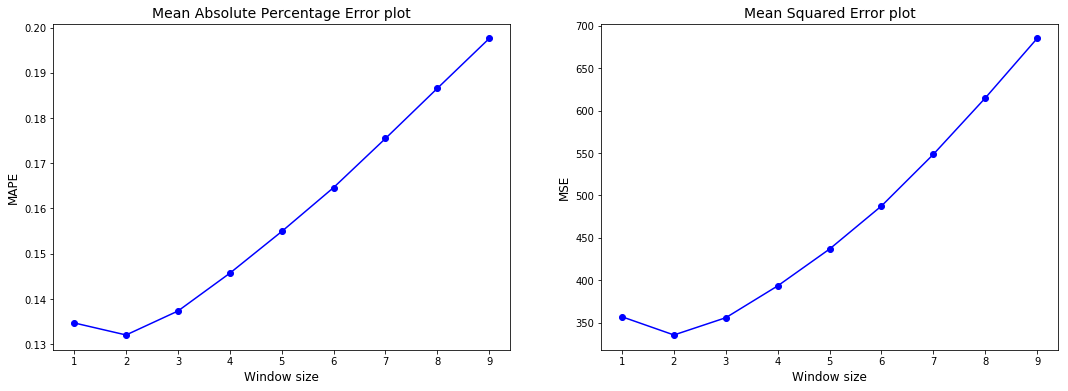

In [69]:
mape_errs = []
mse_errs = []
for window_size in range(1,10):
    a,b,c = MA_P_Predictions(ratios_jan,'jan', window_size)
    mape_errs.append(b)
    mse_errs.append(c)    

print('Best window size is: \n  Based on MAPE: {}\n  Based on MSE : {}\nBut need validation!\n\n'.format(mape_errs.index(min(mape_errs))+1,
                                                                             mse_errs.index(min(mse_errs))+1))
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (18,6))
ax1.plot(range(1,10), mape_errs, 'bo-')
ax1.set_title('Mean Absolute Percentage Error plot', fontsize = 14)
ax1.set_xlabel('Window size', fontsize = 12)
ax1.set_ylabel('MAPE', fontsize = 12)

ax2.plot(range(1,10), mse_errs, 'bo-')
ax2.set_title('Mean Squared Error plot', fontsize = 14)
ax2.set_xlabel('Window size', fontsize = 12)
ax2.set_ylabel('MSE', fontsize = 12)

plt.show()

* Both MSE and MAPE is giving __2__ as best window size.
* So,  $\begin{align}P_{t} = (P_{t-1}+P_{t-2})/2 \end{align}$

### 7.1.2 Weighted Moving Averages


The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones.

Weighted Moving Averages using Ratio Values - 
$\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-N} )/(N*(N+1)/2) \end{align}$

In [0]:
def WA_R_Predictions(ratios,month, window_size):
    predicted_ratio = (ratios['Ratios'].values)[0]
    alpha = 0.5
    error = []
    predicted_values = []
    window_size = window_size
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

**Tunning**

Best window size is: 
  Based on MAPE: 3
  Based on MSE : 7
But need validation!




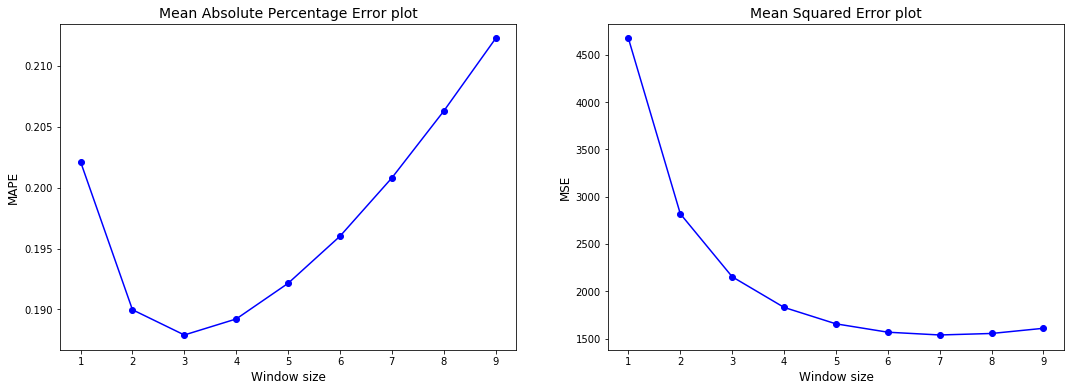

In [71]:
mape_errs = []
mse_errs = []
for window_size in range(1,10):
    a,b,c = WA_R_Predictions(ratios_jan,'jan', window_size)
    mape_errs.append(b)
    mse_errs.append(c)    

print('Best window size is: \n  Based on MAPE: {}\n  Based on MSE : {}\nBut need validation!\n\n'.format(mape_errs.index(min(mape_errs))+1,
                                                                             mse_errs.index(min(mse_errs))+1))
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (18,6))
ax1.plot(range(1,10), mape_errs, 'bo-')
ax1.set_title('Mean Absolute Percentage Error plot', fontsize = 14)
ax1.set_xlabel('Window size', fontsize = 12)
ax1.set_ylabel('MAPE', fontsize = 12)

ax2.plot(range(1,10), mse_errs, 'bo-')
ax2.set_title('Mean Squared Error plot', fontsize = 14)
ax2.set_xlabel('Window size', fontsize = 12)
ax2.set_ylabel('MSE', fontsize = 12)

plt.show()

* MAPE is giving __3__ and MSE is giving __7__ as best window size, but MAPE is our metric so I would pick __3__ as my best window size in this case.
* So,  $\begin{align} R_{t} = ( 3*R_{t-1} + 2*R_{t-2} + 1*R_{t-3} )/6 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [0]:
def WA_P_Predictions(ratios,month, window_size):
    predicted_value = (ratios['Prediction'].values)[0]
    error = []
    predicted_values = []
    window_size = window_size
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

**Tunning**

Best window size is: 
  Based on MAPE: 2
  Based on MSE : 2
But need validation!




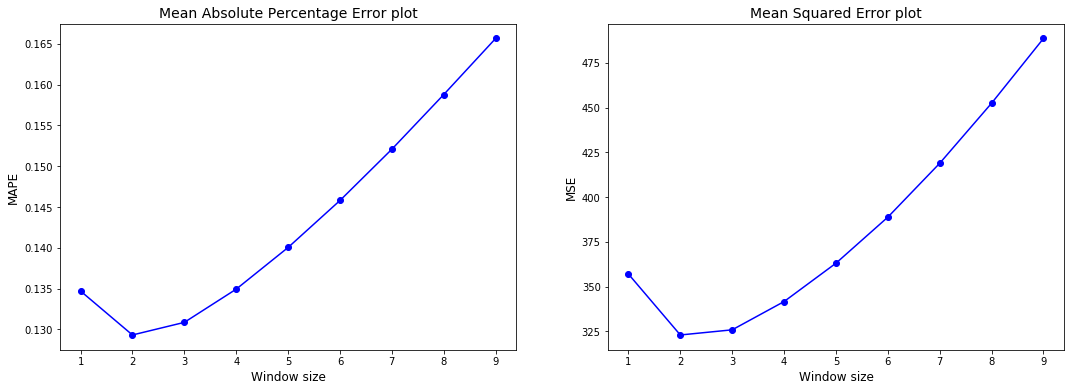

In [73]:
mape_errs = []
mse_errs = []
for window_size in range(1,10):
    a,b,c = WA_P_Predictions(ratios_jan,'jan', window_size)
    mape_errs.append(b)
    mse_errs.append(c)    

print('Best window size is: \n  Based on MAPE: {}\n  Based on MSE : {}\nBut need validation!\n\n'.format(mape_errs.index(min(mape_errs))+1,
                                                                             mse_errs.index(min(mse_errs))+1))
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (18,6))
ax1.plot(range(1,10), mape_errs, 'bo-')
ax1.set_title('Mean Absolute Percentage Error plot', fontsize = 14)
ax1.set_xlabel('Window size', fontsize = 12)
ax1.set_ylabel('MAPE', fontsize = 12)

ax2.plot(range(1,10), mse_errs, 'bo-')
ax2.set_title('Mean Squared Error plot', fontsize = 14)
ax2.set_xlabel('Window size', fontsize = 12)
ax2.set_ylabel('MSE', fontsize = 12)

plt.show()

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2016 values therefore we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

### 7.1.3 Exponential  Weighted Moving Averages

 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
 
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.

For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [0]:
def EA_R1_Predictions(ratios,month, alpha):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=alpha#0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

**Tunning**

Best window size is: 
  Based on MAPE: 0.4
  Based on MSE : 0.7
But need validation!




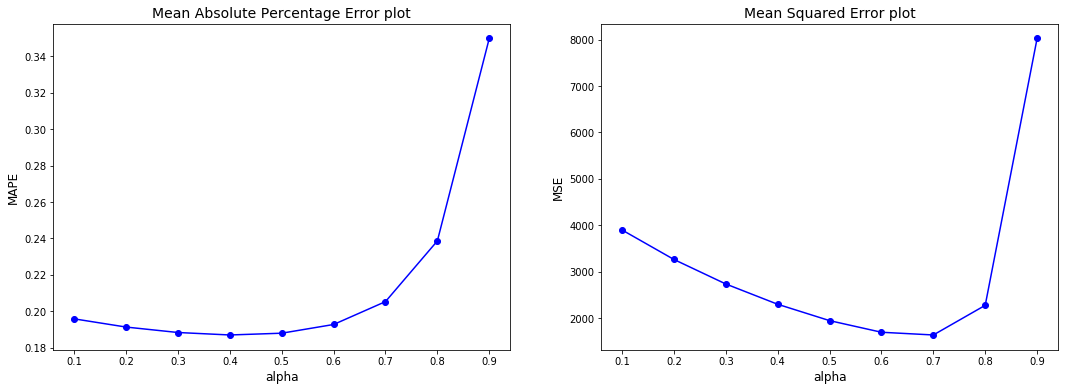

In [75]:
mape_errs = []
mse_errs = []
for window_size in [i/10 for i in range(1,10)]:
    a,b,c = EA_R1_Predictions(ratios_jan,'jan', window_size)
    mape_errs.append(b)
    mse_errs.append(c)    

print('Best window size is: \n  Based on MAPE: {}\n  Based on MSE : {}\nBut need validation!\n\n'.format((mape_errs.index(min(mape_errs))+1)/10,
                                                                             (mse_errs.index(min(mse_errs))+1)/10))
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (18,6))
ax1.plot([i/10 for i in range(1,10)], mape_errs, 'bo-')
ax1.set_title('Mean Absolute Percentage Error plot', fontsize = 14)
ax1.set_xlabel('alpha', fontsize = 12)
ax1.set_ylabel('MAPE', fontsize = 12)

ax2.plot([i/10 for i in range(1,10)], mse_errs, 'bo-')
ax2.set_title('Mean Squared Error plot', fontsize = 14)
ax2.set_xlabel('alpha', fontsize = 12)
ax2.set_ylabel('MSE', fontsize = 12)

plt.show()

* Best alpha value in this case would be 0.4. (i.e. $\begin{align} \alpha = 0.4 \end{align}$)

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [0]:
def EA_P1_Predictions(ratios,month, alpha):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha = alpha#0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

**Tunning**

Best window size is: 
  Based on MAPE: 0.3
  Based on MSE : 0.3
But need validation!




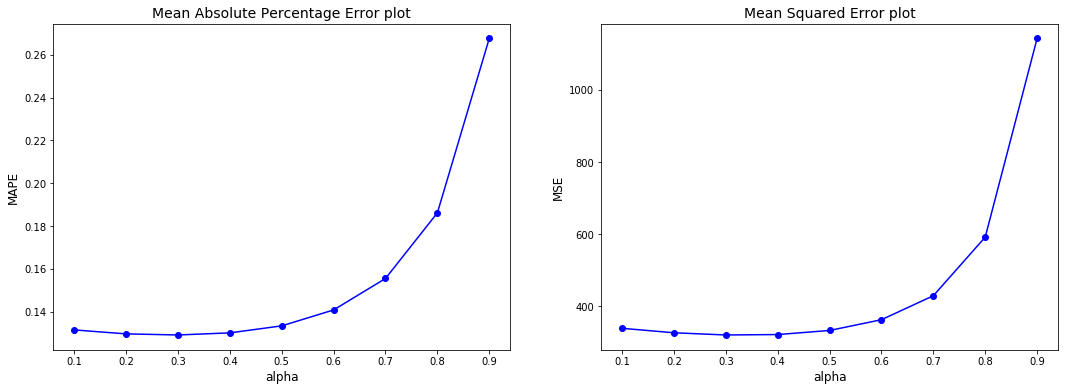

In [77]:
mape_errs = []
mse_errs = []
for window_size in [i/10 for i in range(1,10)]:
    a,b,c = EA_P1_Predictions(ratios_jan,'jan', window_size)
    mape_errs.append(b)
    mse_errs.append(c)    

print('Best window size is: \n  Based on MAPE: {}\n  Based on MSE : {}\nBut need validation!\n\n'.format((mape_errs.index(min(mape_errs))+1)/10,
                                                                             (mse_errs.index(min(mse_errs))+1)/10))
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (18,6))
ax1.plot([i/10 for i in range(1,10)], mape_errs, 'bo-')
ax1.set_title('Mean Absolute Percentage Error plot', fontsize = 14)
ax1.set_xlabel('alpha', fontsize = 12)
ax1.set_ylabel('MAPE', fontsize = 12)

ax2.plot([i/10 for i in range(1,10)], mse_errs, 'bo-')
ax2.set_title('Mean Squared Error plot', fontsize = 14)
ax2.set_xlabel('alpha', fontsize = 12)
ax2.set_ylabel('MSE', fontsize = 12)

plt.show()

* Best alpha value in this case would be 0.3. (i.e. $\begin{align} \alpha = 0.3 \end{align}$)

### 7.1. 4 Comparison between baseline models

We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [0]:
mean_err=[0]*6
median_err=[0]*6
ratios_jan,mean_err[0],median_err[0] = MA_R_Predictions(ratios_jan,'jan', 2)
ratios_jan,mean_err[1],median_err[1] = MA_P_Predictions(ratios_jan,'jan', 2)
ratios_jan,mean_err[2],median_err[2] = WA_R_Predictions(ratios_jan,'jan', 3)
ratios_jan,mean_err[3],median_err[3] = WA_P_Predictions(ratios_jan,'jan', 2)
ratios_jan,mean_err[4],median_err[4] = EA_R1_Predictions(ratios_jan,'jan', 0.4)
ratios_jan,mean_err[5],median_err[5] = EA_P1_Predictions(ratios_jan,'jan', 0.3)

In [79]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.19209981687468133       MSE:  2635.0196684587813
Moving Averages (2016 Values) -                        MAPE:  0.13203859660237668        MSE:  335.5590949820789
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.1879064318619953       MSE:  2152.6944967144564
Weighted Moving Averages (2016 Values) -               MAPE:  0.12931575767723483       MSE:  322.9287559737156
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.1869950477724781       MSE:  2297.0261947431304
Exponential Moving Averages (2016 Values) -         MAPE:  0.1291400237

<b>Plese Note:-</b> The above comparisons are made using Jan 2015 and Jan 2016 only

From the above matrix it is inferred that the best forecasting model for our prediction would be:-
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e Exponential Moving Averages using 2016 Values

## 7. 2 Regression Models

### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

* Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
* number of 10min indices for jan 2015= 24 * 31* 60/10 = 4464
* number of 10min indices for jan 2016 = 24 * 31 * 60/10 = 4464
* number of 10min indices for feb 2016 = 24 * 29 * 60/10 = 4176
* number of 10min indices for march 2016 = 24* 31 * 60/10 = 4464
* regions_cum: it will contain 30 lists, each list will contain 4464+4176+4464 values which represents the number of pickups that are happened for three months in 2016 data


In [0]:
# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible: it is list of lists and it will contain number of pickups 13099 for each cluster
output = []

# tsne_lat: it is list of lists and it will contain 13104-5=13099 times lattitude of cluster center for every cluster
tsne_lat = []

# tsne_lon: it is list of lists and it will contain 13104-5=13099 times logitude of cluster center for every cluster 
tsne_lon = []

# we will code each day: sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# tsne_weekday: it is list of lists
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
tsne_weekday = []

# tsne_feature: its an numpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = [0]*number_of_time_stamps


for i in range(0,30):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [81]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 30*13099 == len(output)*len(output[0])

True

Upto now we've computed 8 features for every data point that starts from 50th min of the day
* 1. cluster center lattitude
* 2. cluster center longitude
* 3. day of the week 
* 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
* 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
* 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
* 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
* 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

From the baseline models we said the exponential weighted moving avarage gives us the best error. So we will try to add the same exponential weighted moving avarage at ***t*** as a feature to our dataNow we'll add  predictions of exponential moving averages to be used as a feature in cumulative form.

In [0]:
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,30):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value = int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

* train, test split : 70% 30% split. Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test,
* Split is done ordered date-wise for every region

In [83]:
#for each cluster:
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [0]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,30)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,30)]

In [85]:
print("Number of data clusters:",len(train_features), 
      ", Number of data points in trian data:", len(train_features[0]),
      "and Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters:",len(train_features), 
      ", Number of data points in test data:", len(test_features[0]), 
      "and Each data point contains", len(test_features[0][0]),"features")

Number of data clusters: 30 , Number of data points in trian data: 9169 and Each data point contains 5 features
Number of data clusters: 30 , Number of data points in test data: 3930 and Each data point contains 5 features


In [0]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [0]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [0]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,30):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,30):
    test_new_features.extend(test_features[i])

In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [121]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(275070, 9)


In [122]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(117900, 9)


In [93]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,270,211,251,238,218,40.769326,-73.95893,4,224
1,211,251,238,218,232,40.769326,-73.95893,4,229
2,251,238,218,232,228,40.769326,-73.95893,4,228
3,238,218,232,228,256,40.769326,-73.95893,4,247
4,218,232,228,256,230,40.769326,-73.95893,4,235


In [95]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train =  std.fit_transform(df_train.values)
X_test  = std.transform(df_test.values)
print('Train Shape: {}\nTest Shape: {}'.format(X_train.shape, X_test.shape))

Train Shape: (275070, 9)
Test Shape: (117900, 9)


### 7.2.1 Using Linear Regression

In [0]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(X_train, tsne_train_output)

y_train_pred_LR = np.round(lr_reg.predict(X_train)).astype(int)
y_test_pred_LR  = np.round(lr_reg.predict(X_test)).astype(int)

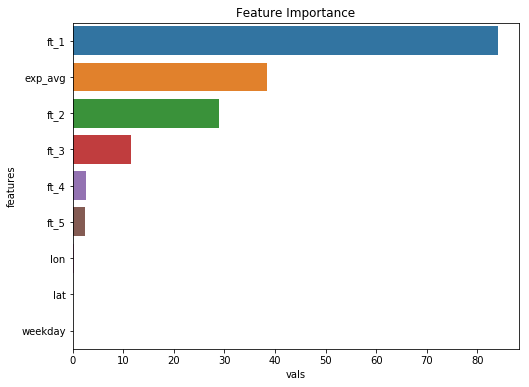

In [107]:
dd = pd.DataFrame({'features': df_train.columns, 'vals': np.abs(lr_reg.coef_)})
dd = dd.sort_values(['vals'], axis = 0, ascending = False)
plt.figure(figsize = (8,6))
sns.barplot(x = 'vals', y = 'features', data = dd)
plt.title('Feature Importance')
plt.show()

### 7.2.2 Using Random Forest Regressor

In [99]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
RF = RandomForestRegressor(max_features='sqrt', n_jobs=-1)
params = {'n_estimators': [50, 100, 300, 500, 1000], 
          'max_depth': [4, 6, 8, 10],
          'min_samples_leaf':[2,4, 6], 
          'min_samples_split': [2,3,5,7]}
rf_model = RandomizedSearchCV(RF, param_distributions = params, scoring = 'neg_mean_absolute_error',
                              refit = True, n_jobs = -1, return_train_score = True)
rf_model.fit(X_train, tsne_train_output)

#get the best hyper-paramter
print("Best hyper-parameter: ", rf_model.best_params_)

#best estmiator
RF = rf_model.best_estimator_
print("Best Estimator: ", RF)

# train with best hyper-parameter
RF.fit(X_train, tsne_train_output)

y_train_pred_RF = np.round(RF.predict(X_train)).astype(int)
y_test_pred_RF  = np.round(RF.predict(X_test)).astype(int)

Best hyper-parameter:  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 10}
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


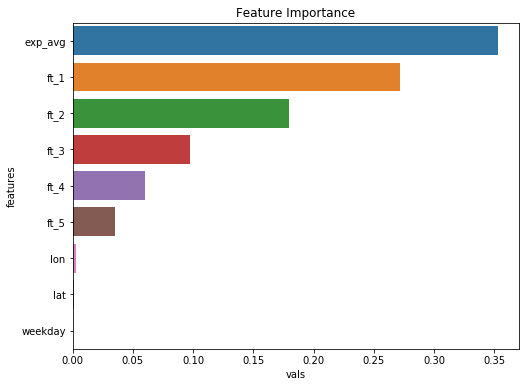

In [100]:
dd = pd.DataFrame({'features': df_train.columns, 'vals': RF.feature_importances_})
dd = dd.sort_values(['vals'], axis = 0, ascending = False)
plt.figure(figsize = (8,6))
sns.barplot(x = 'vals', y = 'features', data = dd)
plt.title('Feature Importance')
plt.show()

### 7.2.3 Using XgBoost Regressor

In [101]:
# http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
XGB_model = xgb.XGBRegressor(learning_rate = 0.1, n_jobs=2)
params = {'n_estimators': [50, 100, 300, 500, 1000],
         'max_depth': [2,3,4,5,8],
         'min_child_weight': [1,2,3,4],
         'gamma' : [0, 0.00001, 0.0001, 0.001, 0.1],
         'subsample':[0.4, 0.6, 0.8, 1],
         'reg_alpha': [0.001,0.1, 10, 50, 100, 200, 500],
         'reg_lambda': [0.001,0.1, 10, 50, 100, 200, 500]}

xgb_model = RandomizedSearchCV(XGB_model, param_distributions = params, scoring = 'neg_mean_absolute_error',
                              refit = True, n_jobs = -1, return_train_score = True)
xgb_model.fit(X_train, tsne_train_output)

#get the best hyper-paramter
print("Best hyper-parameter: ", xgb_model.best_params_)

#best estmiator
XGB_model = xgb_model.best_estimator_
print("Best Estimator: ", XGB_model)

# train with best hyper-parameter
XGB_model.fit(X_train, tsne_train_output)

y_train_pred_xgb = np.round(XGB_model.predict(X_train)).astype(int)
y_test_pred_xgb  = np.round(XGB_model.predict(X_test)).astype(int)

[05:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best hyper-parameter:  {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 100, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 4, 'gamma': 0.0001}
Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.0001,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=3, missing=None, n_estimators=100,
             n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=100, reg_lambda=0.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)
[05:04:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


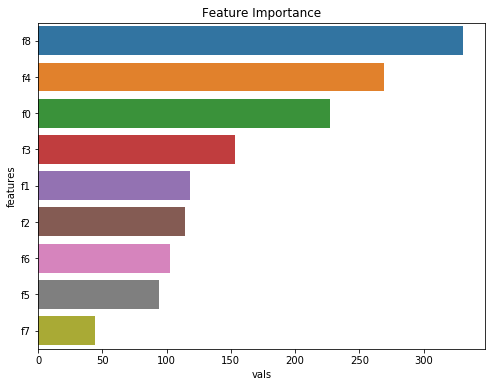

In [102]:
# feature importances: https://stackoverflow.com/a/53640092
feature_imp = XGB_model.get_booster().get_score(importance_type='weight')
feature_imp = dict(sorted(feature_imp.items(), key=lambda x: x[1], reverse=True))

features, vals = [], []
for feature, value in feature_imp.items():
    features.append(feature)
    vals.append(value)

dd = pd.DataFrame({'features': features, 'vals': vals})
plt.figure(figsize = (8,6))
sns.barplot(x = 'vals', y = 'features', data = dd)
plt.title('Feature Importance')
plt.show()

### Calculating the error metric values for various models

* **For Baseline Models**
  * My base line mode is $\begin{align}  (P_{t})_{pred} =((P_{t-1})_{actual}+(P_{t-2})_{actual})/2 \end{align}$. Beacsue after tunining I got best value ***n*** as __2__.
  * So prediction of this can be done very easily by uisng our train and test dataframe. We can predict the value of by $\begin{align} (P_{t})_{pred} =(train\_df['ft\_1']+train\_df['ft\_2'])/2 \end{align}$
* **For Exponential Weighted Moving Average** 
  * Do the prediction using:  $\begin{align} (P_{t})_{pred} = train['exp\_avg'] \end{align}$
* **Regressor Models**
  * Linear Regression
  * Random Forest
  * XgBoost Regressor

In [0]:
train_mape = []
test_mape  = []

# base line model
train_mape.append(mean_absolute_error(tsne_train_output,(df_train['ft_1'].values+df_train['ft_2'].values)/2)/
                  (sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append(mean_absolute_error(tsne_test_output,(df_test['ft_1'].values+df_test['ft_2'].values)/2)/
                  (sum(tsne_test_output)/len(tsne_test_output)))

# EWMA: exponential weighted moving average
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/
                  (sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/
                 (sum(tsne_test_output)/len(tsne_test_output)))

# linear regression
train_mape.append((mean_absolute_error(tsne_train_output, y_train_pred_LR))/
                  (sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, y_test_pred_LR))/
                 (sum(tsne_test_output)/len(tsne_test_output)))

# RF regressor
train_mape.append((mean_absolute_error(tsne_train_output,y_train_pred_RF))/
                  (sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, y_test_pred_RF))/
                 (sum(tsne_test_output)/len(tsne_test_output)))

#XGBoost
train_mape.append((mean_absolute_error(tsne_train_output, y_train_pred_xgb))/
                  (sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, y_test_pred_xgb))/
                 (sum(tsne_test_output)/len(tsne_test_output)))


In [109]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                          Train: ",train_mape[2],"      Test: ",test_mape[2])
print ("Random Forest Regression -                   Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("XgBoost Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.1298527413996297       Test:  0.12142451257678896
Exponential Averages Forecasting -           Train:  0.12691737193278657       Test:  0.11887907709768679
Linear Regression -                          Train:  0.12714273468875997       Test:  0.11874998343739694
Random Forest Regression -                   Train:  0.1219076822475599       Test:  0.11625139646404514
XgBoost Regression -                         Train:  0.12433178877360346       Test:  0.11687992358866746
--------------------------------------------------------------------------------------------------------


In [0]:
from prettytable import PrettyTable

# without adding Fourier transformed features
# http://zetcode.com/python/prettytable/
table1 = PrettyTable()
table1.field_names = ["Model Name", "Train MAPE", "Test MAPE"]
table1.add_row(["Base Line Model", round(train_mape[0], 4), round(test_mape[0], 4)])
table1.add_row(["Exponential Wieghted Moving Average", round(train_mape[1], 4), round(test_mape[1], 4)])
table1.add_row(["Linear Regression", round(train_mape[2], 4), round(test_mape[2], 4)])
table1.add_row(["Random Forest Regressor", round(train_mape[3], 4), round(test_mape[3], 4)])
table1.add_row(["XgBoost Regressor", round(train_mape[4], 4), round(test_mape[4], 4)])


## 7.3 Regressor Model with more features

### 7.3.1 Adding Featues

#### 7.3.1.1 Fourier Transformed Features

* We'll select top 3 ampletudes and corresponding frequencies.
* To do so, I'll use only Jan and Feb data of 2016 to get these values of each cluster and then we'll add these values in same cluster of test data

ref: [For ampletudes](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html#numpy.fft.fftfreq)

[For frquencies](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html#numpy.fft.fft)

In [0]:
# for train data
fft_amp = [0]*3 #it is list if list: each list will contain top 5 ampletudes for each cluster
fft_freq= [0]*3 ##it is list if list: each list will contain top 5 frequencies
for i in range(0,30):
    a = np.fft.fft(regions_cum[i][0:4464+4176])
    b = np.fft.fftfreq(4464+4176, 1)
    a = np.abs(a)
    fft_amp  = np.vstack((fft_amp, a[0:3]))
    fft_freq = np.vstack((fft_freq, b[0:3]))
fft_amp = fft_amp[1:]
fft_freq = fft_freq[1:]
amp_freq = np.hstack((fft_amp, fft_freq))

fft_feature_train = [[amp_freq[i]]*9169 for i in range(30)] # for jan and feb
fft_feature_train = sum(fft_feature_train, []) #

fft_feature_test  = [[amp_freq[i]]*3930 for i in range(30)] #for March data
fft_feature_test = sum(fft_feature_test, [])

#### 7.3.1.2 Adding Mean, Median, Max and Min 

* There are 31 days in Jan and 29 days in Feb of 2016. I'll use train data (Jan and Feb) to get these featues. These features will be calculated daywise which means for exapmle: weekday = 1: collect all pickup of weekday 1 from both month and calculate the features.
* But from data for each day we're getting minimum value **0**. So we're not going add this features

In [124]:
# basic_feat: list of lists, each list corresponds to each day
# first list will correspond to weekday == 1.

basic_feat = []
a = df_train.copy()
a['Pickups'] = tsne_train_output

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html
get_mean   = list(a[['weekday', 'Pickups']].groupby('weekday').mean()['Pickups'].values.astype(int))
get_median =  list(a[['weekday', 'Pickups']].groupby('weekday').median()['Pickups'].values)
get_max    = list(a[['weekday', 'Pickups']].groupby('weekday').max()['Pickups'].values)
get_min    = list(a[['weekday', 'Pickups']].groupby('weekday').min()['Pickups'].values)

basic_feat.append(get_mean)
basic_feat.append(get_median)
basic_feat.append(get_max)
basic_feat.append(get_min)

print('Mean   :{}\nMedian :{}\nMax    :{}\nMin    :{}'.format(basic_feat[0], basic_feat[1], basic_feat[2], basic_feat[3]))


Mean   :[87, 83, 82, 84, 83, 83, 81]
Median :[55, 55, 58, 58, 53, 55, 48]
Max    :[753, 481, 424, 465, 479, 659, 662]
Min    :[0, 0, 0, 0, 0, 0, 0]


#### 7.3.1.4 Concatenate Features

In [0]:
# for FFT features
def add_fft_feature(df, list_data):
    df[['amp'+str(i) for i in range(3)]+['freq'+str(i) for i in range(3)]] = pd.DataFrame(data = list_data, index = df.index)    
    return df

# for basic features: mean, meadin, max and min  
def add_basic_featue(df):
    my_mean = []
    my_median = []
    my_max = []
    weekdays = df['weekday'].values
    for i in range(7):
        
        for j in weekdays:
            if i == j:
                my_mean.append(basic_feat[0][i])
                my_median.append(basic_feat[1][i])
                my_max.append(basic_feat[2][i])
    df['mean']   = my_mean 
    df['median'] = my_median
    df['max']    = my_max
    
    return df

def featurize_df(df, list_data):
    df = add_basic_featue(df)
    df = add_fft_feature(df, list_data)
    
    return df

In [128]:
df_train = featurize_df(df_train, fft_feature_train)
df_test  = featurize_df(df_test, fft_feature_test)
print('Shape of train data: {}\nShape of test data:  {}'.format(df_train.shape, df_test.shape))
X_train = df_train.values
X_test  = df_test.values
df_test.head()

Shape of train data: (275070, 18)
Shape of test data:  (117900, 18)


,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,mean,median,max,amp0,amp1,amp2,freq0,freq1,freq2
0,270,211,251,238,218,40.769326,-73.95893,4,224,87,55,753,1306895.0,17149.759047,39391.176511,0.0,0.000116,0.000231
1,211,251,238,218,232,40.769326,-73.95893,4,229,87,55,753,1306895.0,17149.759047,39391.176511,0.0,0.000116,0.000231
2,251,238,218,232,228,40.769326,-73.95893,4,228,87,55,753,1306895.0,17149.759047,39391.176511,0.0,0.000116,0.000231
3,238,218,232,228,256,40.769326,-73.95893,4,247,87,55,753,1306895.0,17149.759047,39391.176511,0.0,0.000116,0.000231
4,218,232,228,256,230,40.769326,-73.95893,4,235,87,55,753,1306895.0,17149.759047,39391.176511,0.0,0.000116,0.000231


In [130]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(df_train.values)
X_test  = std.transform(df_test.values)
print('Train shape: {} and Test Shape: {}'.format(X_train.shape, X_test.shape))

Train shape: (275070, 18) and Test Shape: (117900, 18)


### 7.3.2 Regressor Models

#### 7.3.2.1 Linear Regression

In [0]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(X_train, tsne_train_output)

y_train_pred_LR = np.round(lr_reg.predict(X_train)).astype(int)
y_test_pred_LR  = np.round(lr_reg.predict(X_test)).astype(int)

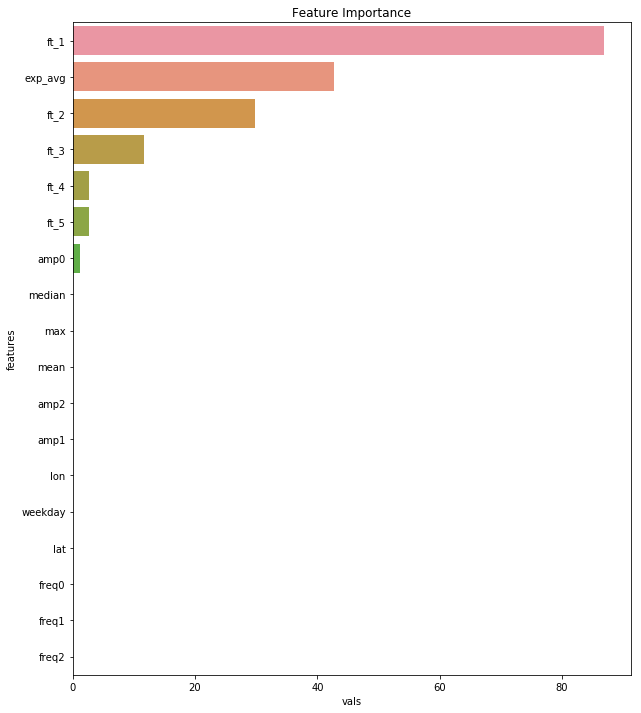

In [134]:
dd = pd.DataFrame({'features': df_train.columns, 'vals': np.abs(lr_reg.coef_)})
dd = dd.sort_values(['vals'], axis = 0, ascending = False)
plt.figure(figsize = (10,12))
sns.barplot(x = 'vals', y = 'features', data = dd)
plt.title('Feature Importance')
plt.show()

#### 7.3.2.2 Random Forest

In [135]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
RF = RandomForestRegressor(max_features='sqrt', n_jobs=-1)
params = {'n_estimators': [50, 100, 300, 500, 1000], 
          'max_depth': [4, 6, 8, 10],
          'min_samples_leaf':[2,4, 6], 
          'min_samples_split': [2,3,5,7]}
rf_model = RandomizedSearchCV(RF, param_distributions = params, scoring = 'neg_mean_absolute_error',
                              refit = True, n_jobs = -1, return_train_score = True)
rf_model.fit(X_train, tsne_train_output)

#get the best hyper-paramter
print("Best hyper-parameter: ", rf_model.best_params_)

#best estmiator
RF = rf_model.best_estimator_
print("Best Estimator: ", RF)

# train with best hyper-parameter
RF.fit(X_train, tsne_train_output)

y_train_pred_RF = np.round(RF.predict(X_train)).astype(int)
y_test_pred_RF  = np.round(RF.predict(X_test)).astype(int)

Best hyper-parameter:  {'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_depth': 10}
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=7,
                      min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


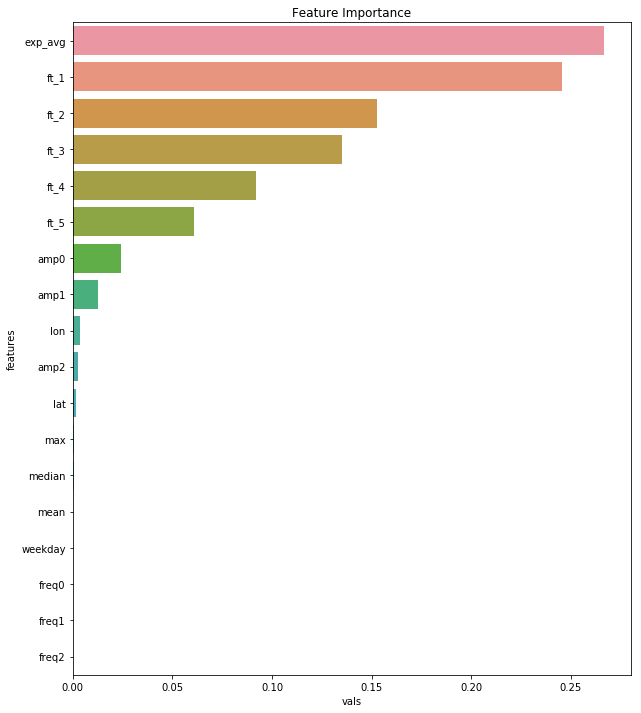

In [136]:
dd = pd.DataFrame({'features': df_train.columns, 'vals': RF.feature_importances_})
dd = dd.sort_values(['vals'], axis = 0, ascending = False)
plt.figure(figsize = (10,12))
sns.barplot(x = 'vals', y = 'features', data = dd)
plt.title('Feature Importance')
plt.show()

#### 7.3.2.3 XgBoost

In [137]:
# http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
XGB_model = xgb.XGBRegressor(learning_rate = 0.1, n_jobs=2)
params = {'n_estimators': [50, 100, 300, 500, 1000],
         'max_depth': [2,3,4,5,8],
         'min_child_weight': [1,2,3,4],
         'gamma' : [0, 0.00001, 0.0001, 0.001, 0.1],
         'subsample':[0.4, 0.6, 0.8, 1],
         'reg_alpha': [0.001,0.1, 10, 50, 100, 200, 500],
         'reg_lambda': [0.001,0.1, 10, 50, 100, 200, 500]}

xgb_model = RandomizedSearchCV(XGB_model, param_distributions = params, scoring = 'neg_mean_absolute_error',
                              refit = True, n_jobs = -1, return_train_score = True)
xgb_model.fit(X_train, tsne_train_output)

#get the best hyper-paramter
print("Best hyper-parameter: ", xgb_model.best_params_)

#best estmiator
XGB_model = xgb_model.best_estimator_
print("Best Estimator: ", XGB_model)

# train with best hyper-parameter
XGB_model.fit(X_train, tsne_train_output)

y_train_pred_xgb = np.round(XGB_model.predict(X_train)).astype(int)
y_test_pred_xgb  = np.round(XGB_model.predict(X_test)).astype(int)

[07:48:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best hyper-parameter:  {'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 500, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'gamma': 0.001}
Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=3, missing=None, n_estimators=300,
             n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=500, reg_lambda=200, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)
[07:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


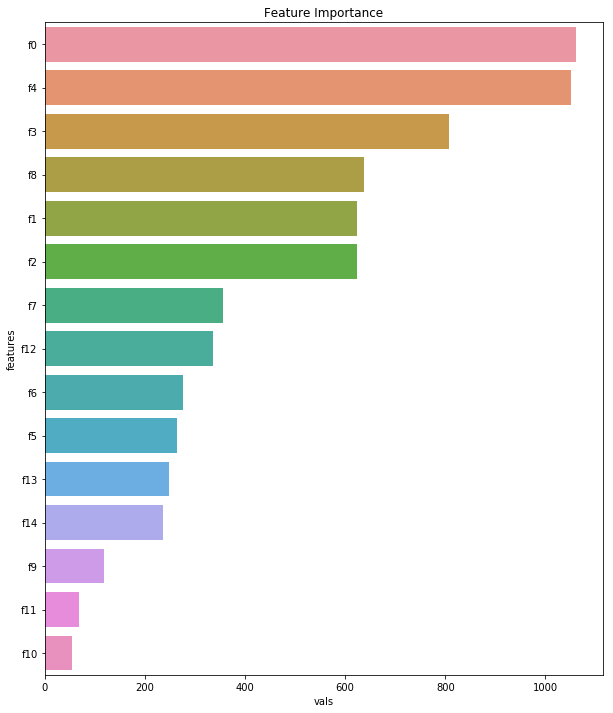

In [138]:
# feature importances: https://stackoverflow.com/a/53640092
feature_imp = XGB_model.get_booster().get_score(importance_type='weight')
feature_imp = dict(sorted(feature_imp.items(), key=lambda x: x[1], reverse=True))

features, vals = [], []
for feature, value in feature_imp.items():
    features.append(feature)
    vals.append(value)

dd = pd.DataFrame({'features': features, 'vals': vals})
plt.figure(figsize = (10,12))
sns.barplot(x = 'vals', y = 'features', data = dd)
plt.title('Feature Importance')
plt.show()

### 7.4 Error Metric Matrix

In [0]:
train_mape = []
test_mape  = []

# base line model
train_mape.append(mean_absolute_error(tsne_train_output,(df_train['ft_1'].values+df_train['ft_2'].values)/2)/
                  (sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append(mean_absolute_error(tsne_test_output,(df_test['ft_1'].values+df_test['ft_2'].values)/2)/
                  (sum(tsne_test_output)/len(tsne_test_output)))

# EWMA: exponential weighted moving average
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/
                  (sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/
                 (sum(tsne_test_output)/len(tsne_test_output)))

# linear regression
train_mape.append((mean_absolute_error(tsne_train_output, y_train_pred_LR))/
                  (sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, y_test_pred_LR))/
                 (sum(tsne_test_output)/len(tsne_test_output)))

# RF regressor
train_mape.append((mean_absolute_error(tsne_train_output,y_train_pred_RF))/
                  (sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, y_test_pred_RF))/
                 (sum(tsne_test_output)/len(tsne_test_output)))

#XGBoost
train_mape.append((mean_absolute_error(tsne_train_output, y_train_pred_xgb))/
                  (sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, y_test_pred_xgb))/
                 (sum(tsne_test_output)/len(tsne_test_output)))


In [140]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                          Train: ",train_mape[2],"      Test: ",test_mape[2])
print ("Random Forest Regression -                   Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("XgBoost Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.1298527413996297       Test:  0.12142451257678896
Exponential Averages Forecasting -           Train:  0.12691737193278657       Test:  0.11887907709768679
Linear Regression -                          Train:  0.1272835537940942       Test:  0.11847617994823381
Random Forest Regression -                   Train:  0.12163861251170359       Test:  0.11559258343671552
XgBoost Regression -                         Train:  0.12201540581887332       Test:  0.11508103561130013
--------------------------------------------------------------------------------------------------------


In [0]:
# without adding Fourier transformed features
# http://zetcode.com/python/prettytable/
table2 = PrettyTable()
table2.field_names = ["Model Name", "Train MAPE", "Test MAPE"]
table2.add_row(["Base Line Model", round(train_mape[0], 4), round(test_mape[0], 4)])
table2.add_row(["Exponential Wieghted Moving Average", round(train_mape[1], 4), round(test_mape[1], 4)])
table2.add_row(["Linear Regression", round(train_mape[2], 4), round(test_mape[2], 4)])
table2.add_row(["Random Forest Regressor", round(train_mape[3], 4), round(test_mape[3], 4)])
table2.add_row(["XgBoost Regressor", round(train_mape[4], 4), round(test_mape[4], 4)])

# 8. Conclusion

**Summary**
* This project about predicting the number of pickups in given region in next 10 minutes interval. First ernous points are from the data like if pickup and drop-off location is out side of NYC, if speed is too high, if total fair is too high, etc. We've divided the NYC into 30 regions (using latitude and longitude of data as input for K-means). We've devided each day with 10 minutes interval, so each day has 144 data points. So In one cluster or region, we've 144 datapoints for one day. 
* Base line models were created and their performance is very good, even their performace is alsot same very complex like Random Forest and XgBoost model. 
* First we trained regressor models using only last five days pickups cluster centroid (as latitde and longitude) and exponential weighted moving average of picups. With these features **Radom Forest** is giving best MAPE(**0.1163**) value and simple model (exponential weighted moving average) is giving MAPE (**0.1189**)
* After adding the fourier transformed features (3 ampletude and corresponding frequencies), mean, median, max features. Then again trained the regressor model and found that **XgBoost** is giving best MAPE value (i.e.**0.1151**).

**Note:** Even after Fourier Tranformed features there is not much reduction in MAPE.

In [148]:
table1.sortby = 'Test MAPE'
table1.reversesort = False
print(table1)

+-------------------------------------+------------+-----------+
|              Model Name             | Train MAPE | Test MAPE |
+-------------------------------------+------------+-----------+
|       Random Forest Regressor       |   0.1219   |   0.1163  |
|          XgBoost Regressor          |   0.1243   |   0.1169  |
|          Linear Regression          |   0.1271   |   0.1187  |
| Exponential Wieghted Moving Average |   0.1269   |   0.1189  |
|           Base Line Model           |   0.1299   |   0.1214  |
+-------------------------------------+------------+-----------+


In [150]:
table2.sortby = 'Test MAPE'
table2.reversesort = False
print(table2)

+-------------------------------------+------------+-----------+
|              Model Name             | Train MAPE | Test MAPE |
+-------------------------------------+------------+-----------+
|          XgBoost Regressor          |   0.122    |   0.1151  |
|       Random Forest Regressor       |   0.1216   |   0.1156  |
|          Linear Regression          |   0.1273   |   0.1185  |
| Exponential Wieghted Moving Average |   0.1269   |   0.1189  |
|           Base Line Model           |   0.1299   |   0.1214  |
+-------------------------------------+------------+-----------+
